In [1]:
# Referenced from Tensorflow Tutorials: https://www.tensorflow.org/tutorials/images/transfer_learning
# Images from: https://github.com/cabani/MaskedFace-Net
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [2]:

INIT_LR = 1e-4
EPOCHS = 7
BS = 64

print("[INFO] loading images...")
imagePaths = list(paths.list_images("./train"))
data = []
labels = []
for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [3]:
labels = np.array(labels)

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [5]:
len(labels)

2697

In [6]:

(trainX, testX, trainY, testY) = train_test_split(np.stack(data), labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [22]:

baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

In [23]:
trainX.shape

(2157, 224, 224, 3)

In [24]:

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/7
33/33 [==============================] - 123s 4s/step - loss: 0.4948 - accuracy: 0.6445 - val_loss: 0.2559 - val_accuracy: 0.8926
Epoch 2/7
33/33 [==============================] - 113s 3s/step - loss: 0.2049 - accuracy: 0.8991 - val_loss: 0.1583 - val_accuracy: 0.9278
Epoch 3/7
33/33 [==============================] - 112s 3s/step - loss: 0.1463 - accuracy: 0.9226 - val_loss: 0.1194 - val_accuracy: 0.9481
Epoch 4/7
33/33 [==============================] - 112s 3s/step - loss: 0.1161 - accuracy: 0.9408 - val_loss: 0.1012 - val_accuracy: 0.9556
Epoch 5/7
33/33 [==============================] - 113s 3s/step - loss: 0.1082 - accuracy: 0.9422 - val_loss: 0.0905 - val_accuracy: 0.9574
Epoch 6/7
33/33 [==============================] - 113s 3s/step - loss: 0.0904 - accuracy: 0.9560 - val_loss: 0.0793 - val_accuracy: 0.9667
Epoch 7/7
33/33 [==============================] - 112s 3s/step - loss: 0.0916 - accuracy: 0.9498 - val_loss: 

In [25]:

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save("new model", save_format="h5")

[INFO] evaluating network...
                 precision    recall  f1-score   support

   mask_correct       0.96      0.97      0.96       178
mask_worn_wrong       0.95      0.96      0.95       182
        no_mask       1.00      0.98      0.99       180

       accuracy                           0.97       540
      macro avg       0.97      0.97      0.97       540
   weighted avg       0.97      0.97      0.97       540

[INFO] saving mask detector model...


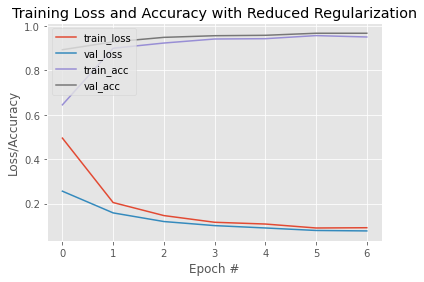

In [32]:

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy with Reduced Regularization")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("new_plot")